## Итоговый проект: «От дерева решений к ансамблю и кластеризации»


### Цель проекта
  Цель проекта - закрепить понимание принципов работы алгоритмов деревьев решений, ансамблей и кластеризации через собственную реализацию и анализ их поведения на данных.

### Задачи проекта

  1. Реализовать базовые версии алгоритмов с нуля, используя numpy и pandas
  2. Провести эксперименты с параметрами и сравните результаты с реализациями из sklearn
  3. Научиться интерпретировать результаты и визуализировать их.

### Этап 1. Реализация дерева решений
На этом этапе создадим простую реализацию дерева решений для задачи классификации.

In [2]:
#1. Сгенерируем небольшой набор данных (100–300 наблюдений):

from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=300,
    n_features=2,  # два признака для наглядной визуализации границ решений
    n_informative=2,
    n_redundant=0,
    random_state=42
)

In [3]:
#2. Преобразуем данные в pandas.DataFrame.
import pandas as pd
X_df= pd.DataFrame(X, columns=['feature1', 'feature2'])
X_df['target'] = y
X_df['target'].value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [4]:
# 3. Реализуем функции:
# 3.1. Расчета энтропии

import numpy as np

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy
    

In [225]:
# 3.2. Поиска наилучшего разбиения по признаку

# 3.2.1 Сначала определим функцию для поиска кандидатов в пороговые значения

def find_candidates_for_thresholds(x, y):
    
    unique_sorted = np.sort(np.unique(x))
    
    # Вычисляем среднее между соседними значениями   
    candidates = (unique_sorted[1:] + unique_sorted[:-1]) / 2.0
    
    return candidates

# 3.2.2. Создадим функцию, которая разбивает выборку по предикату

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

# 3.2.3. Cоздадим функцию, рассчитывающую взвешенную неоднородность после разбиения
# в качестве критерия информативности возьмем энтропию

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

# 3.2.4 Определим функцию наилучшего разбиения

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [226]:
# 3.3. Определим функцию рекурсивного построения дерева с ограничением по глубине (max_depth)

# 3.3.1. Создадим вспомогательный класс вершины:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf
    
# функция предсказания для листа дерева решений: 
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

# 3.3.2. Напишем саму функцию рекурсивного построения дерева

def build_decision_tree(X, y, criterion, max_depth, current_depth=0):
    
    if current_depth >= max_depth:
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
        return node
    else:
        split_params = best_split(X, y, criterion=criterion)
        
        # Если не найдено разбиение - создаем лист
        if split_params is None:
            value = create_leaf_prediction(y)
            node = Node(
                value=value, 
                impurity=criterion(y), 
                samples=y.size,
                is_leaf=True
            )
        else:
            X_left, y_left, X_right, y_right = split(X, y, split_params)
            
            left = build_decision_tree(X_left, y_left, criterion, max_depth, current_depth + 1)
            right = build_decision_tree(X_right, y_right, criterion, max_depth, current_depth + 1)       
            node = Node(
                left=left, right=right, 
                split_params=split_params, 
                impurity=criterion(y), 
                samples=y.size
            )
    
    return node

In [227]:
# 3.4. Определим функцию для получения предсказаний по новым наблюдениям

# 3.4.1. Сначала напишем функцию, которая выдает предсказание,
# получая на входе объект из выборки и вершину

def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# 3.4.2. Теперь создадим функцию, которая выводит предсказания для всех объектов в выборке
    
def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

##### Тестирование модели

  Dataset  Accuracy
0   Train     0.967
1    Test     0.944


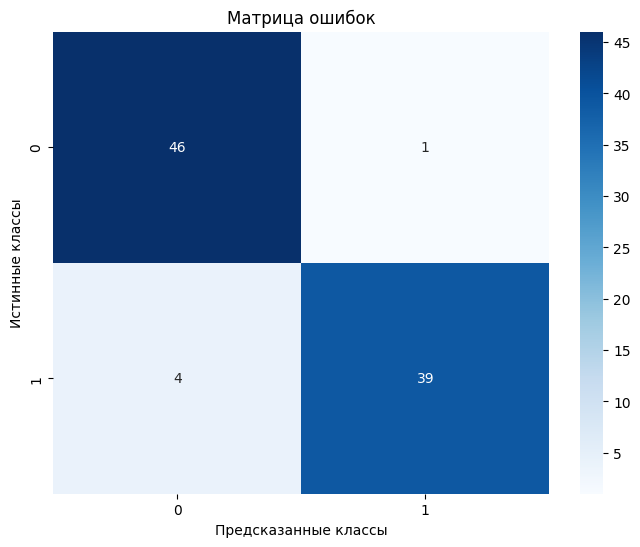

In [ ]:
# 1. Разделим данные на обучающую и тестовую выборки (с помощью train_test_split),
# зафиксировав random_state=42 для воспроизводимости)

from sklearn.model_selection import train_test_split

X = X_df.drop('target', axis = 1)
y = X_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

# 2. Обучим модель
tree = build_decision_tree(X_train, y_train, criterion=entropy, max_depth=3, current_depth=0)
# глубина 3 была выбрана эмпирическим путем на основании сравнения абсолютного значения accuracy
# и разрыва между значением на тесте и на обучающей выборке при различной глубине

# 3. Выполним предсказание

y_train_pred = predict(tree, X_train)
y_test_pred = predict(tree, X_test)

# 4. Рассчитаем и проанализируем метрику accuracy_score, а также посмотрим на матрицу ошибок
# (классы сбалансированы, поэтому можем использовать accuracy_score)

from sklearn.metrics import accuracy_score, confusion_matrix

metrics_simple = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ]
}

metrics_simple_df = pd.DataFrame(metrics_simple)

print(metrics_simple_df.round(3))

# Визуализируем матрицу ошибок:

cm = confusion_matrix(y_test, y_test_pred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

In [230]:
# Выведем на экран полученное дерево
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        j, t = node.split_params
        
        print('   ' * depth, 'feature{} <= {:.3f}:'.format(j+1, t))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature{} > {:.3f}:'.format(j+1, t))
        print_decision_tree(node.right, depth=depth)
print_decision_tree(tree)

    feature1 <= -0.052:
       feature1 <= -0.469:
          feature2 <= 1.714:
             class: 0
          feature2 > 1.714:
             class: 0
       feature1 > -0.469:
          feature2 <= 0.615:
             class: 0
          feature2 > 0.615:
             class: 1
    feature1 > -0.052:
       feature1 <= 0.609:
          feature2 <= 0.413:
             class: 0
          feature2 > 0.413:
             class: 1
       feature1 > 0.609:
          feature1 <= 0.952:
             class: 1
          feature1 > 0.952:
             class: 1


##### Реализуем алгоритм дерева решений с помощью DecisionTreeClassifier из sklearn. Сравним результаты

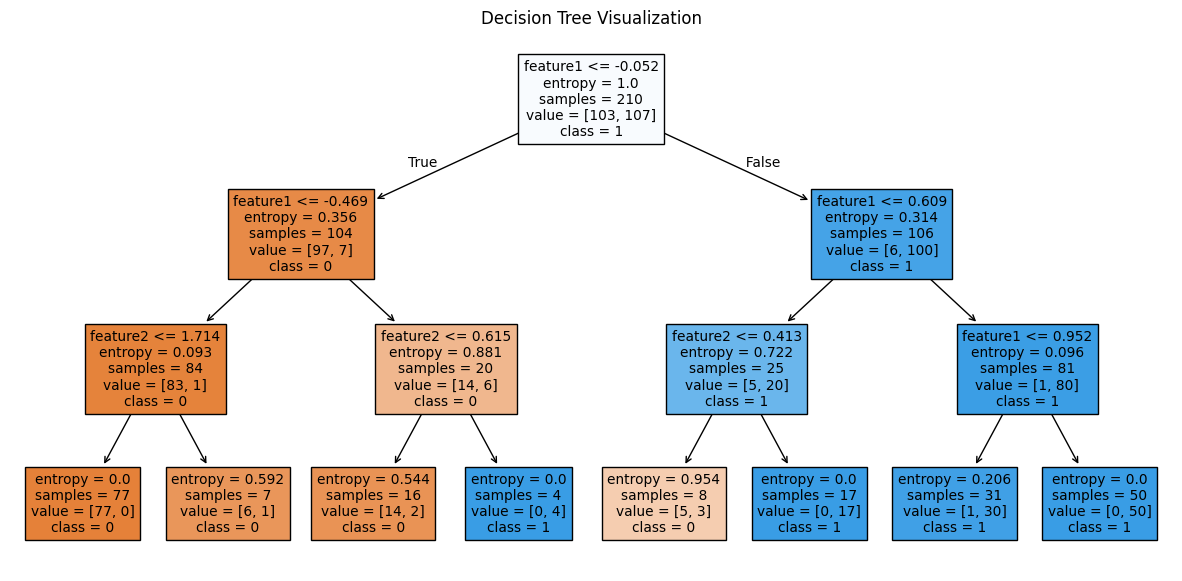

In [231]:
# Обучим дерево и визуализируем его

from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(max_depth = 3, criterion='entropy', random_state=42)
dt.fit(X_train, y_train)


fig = plt.figure(figsize=(15, 7))
plot_tree(
    dt,  
    feature_names=X.columns, 
    class_names=['0', '1'],
    filled=True, 
    impurity=True
)
plt.title("Decision Tree Visualization")
plt.show()

In [232]:
# Получим предсказания

y_pred_test_sl = dt.predict(X_test)
y_pred_train_sl = dt.predict(X_train)

In [233]:
metrics_sklearn = {
    'Dataset': ['Train', 'Test'],
    'Accuracy_sklearn': [
        accuracy_score(y_train, y_pred_train_sl),
        accuracy_score(y_test, y_pred_test_sl)
    ],
    'Accuracy_custom': [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ]
}

metrics_comparison_df = pd.DataFrame(metrics_sklearn)
print("СРАВНЕНИЕ МЕТРИК:")
print(metrics_comparison_df.round(3))

СРАВНЕНИЕ МЕТРИК:
  Dataset  Accuracy_sklearn  Accuracy_custom
0   Train             0.967            0.967
1    Test             0.944            0.944


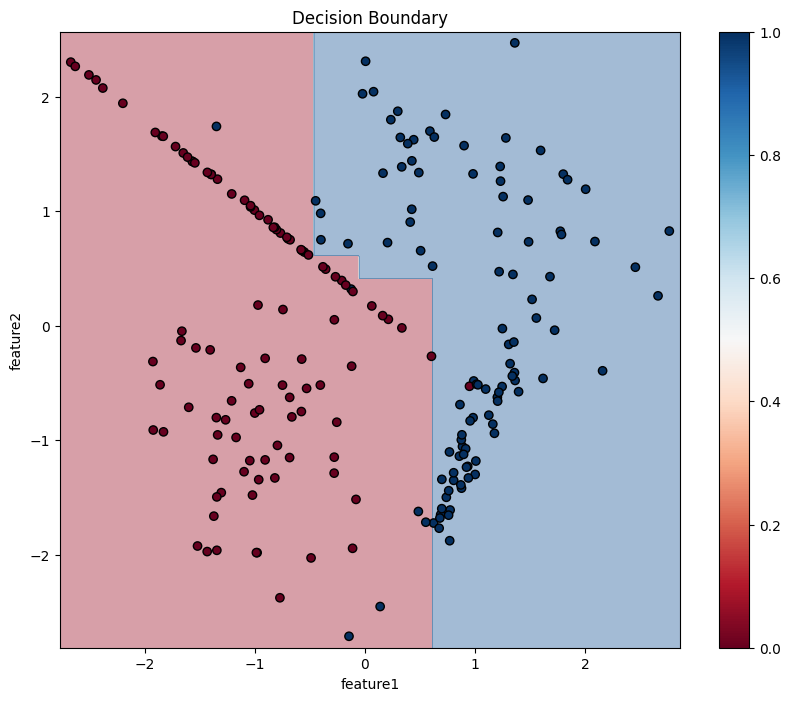

In [234]:
# Построим график границ решений

def plot_decision_boundary(model, X, y):
    # Определяем границы
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    
    # Создаем сетку
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Создаем DataFrame для предсказания
    grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], 
                              columns=X.columns)
    
    # Предсказания для каждой точки сетки
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Построение графика
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='RdBu', edgecolor='black')
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()

plot_decision_boundary(dt, X_train, y_train)


#### Выводы:
1. Структура дерева и значения метрики accuracy при "ручной" реализации точно совпадают с реализацией с помощью sklearn с теми же параметрами. Это говорит о корректности построенного "ручного" алгоритма.

2. Метрика Accuracy на тестовой выборке немного ниже, чем на тренировочных данных, что говорит о незначительной переобученности. Однако поскольку на тестовых данных значение Accuracy является высоким (0,944), построенную модель считаем допустимой для дальнейших расчетов.

### Этап 2. Ансамбль деревьев (бэггинг) 

#### Напишем функцию, которая:

1. Случайно выбирает bootstrap-выборку (с возвращением) из обучающих данных размером, равным обучающей выборке
2. Обучает на ней одно дерево решений
3. Сохраняет модель

Сделаем деревья решений для бэггинга большей глубины (max_depth=4), чем в реализации модели одного дерева (max_depth=3). Мы намеренно делаем дерево несколько переобученным, чтобы в результате бэггинга на слабых (в данном случае переобученных) деревьях получить лучший результат.

In [235]:
def tree_for_begging (X, y, random_state):
    
    np.random.seed(random_state)
    n_samples = len(X)
    
    # Генерируем случайные индексы с возвращением
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    
    # Создаем bootstrap-выборку
    X_bootstrap = X.iloc[indices].reset_index(drop=True)
    y_bootstrap = y.iloc[indices].reset_index(drop=True)
    
    #обучим модель
    tree_i = build_decision_tree(X_bootstrap, y_bootstrap, criterion=entropy, max_depth=4, current_depth=0)
    
    return tree_i
    
   

#### Повторим процесс несколько раз — для N = 5

In [236]:
trees_5 = []
predictions_train_5 = {}  # словарь для предсказаний на обучающей выборке
predictions_test_5 = {}   # словарь для предсказаний на тестовой выборке

for i in range(5):
    tree = tree_for_begging(X_train, y_train, random_state=42+i)
    tree.name = f"tree_{i}"  
    trees_5.append(tree)
    
    predictions_train_5[f"tree_{i}"] = predict(tree, X_train)
    predictions_test_5[f"tree_{i}"] = predict(tree, X_test)
    
    print(f"Создано {tree.name}")
    

Создано tree_0
Создано tree_1
Создано tree_2
Создано tree_3
Создано tree_4


Объединим предсказания посредством голосования большинством

In [237]:
def majority_vote(predictions_dict):
   
    # Преобразуем словарь в numpy array
    all_predictions = np.array(list(predictions_dict.values()))
    
    # Голосование большинством для каждого объекта
    final_predictions = []
    for i in range(all_predictions.shape[1]):
        votes = all_predictions[:, i]  # голоса всех моделей для i-го объекта
        most_common = np.bincount(votes).argmax()  # самый частый класс
        final_predictions.append(most_common)
    
    return np.array(final_predictions)

# Применяем голосование большинством
y_ensemble_test = majority_vote(predictions_test_5)
y_ensemble_train = majority_vote(predictions_train_5)


Проверим, что деревья в ансамбле отличаются друг от друга.
Для этого выполним следующий тест:

In [267]:
tree1 = tree_for_begging(X_train, y_train, random_state=42)
tree2 = tree_for_begging(X_train, y_train, random_state=43)

print ('Дерево 1')    
print_decision_tree(tree1)
print ('Дерево 2')   
print_decision_tree(tree2)

Дерево 1
    feature1 <= -0.164:
       feature1 <= -0.404:
          feature2 <= 1.714:
             feature1 <= -1.882:
                class: 0
             feature1 > -1.882:
                class: 0
          feature2 > 1.714:
             feature1 <= -1.773:
                class: 0
             feature1 > -1.773:
                class: 1
       feature1 > -0.404:
          feature1 <= -0.339:
             feature1 <= -0.401:
                class: 1
             feature1 > -0.401:
                class: 1
          feature1 > -0.339:
             feature1 <= -0.278:
                class: 0
             feature1 > -0.278:
                class: 0
    feature1 > -0.164:
       feature1 <= 0.255:
          feature2 <= 0.188:
             feature1 <= -0.133:
                class: 1
             feature1 > -0.133:
                class: 0
          feature2 > 0.188:
             feature1 <= -0.140:
                class: 1
             feature1 > -0.140:
                class: 1
  

Вывод: деревья отличаются по структуре и пороговым значениям. Это признак корректной реализации бэггинга. Переходим к следующим пунктам задачи

Оценим качество прогноза

In [238]:
metrics_simple_5 = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_ensemble_train),
        accuracy_score(y_test, y_ensemble_test)
    ]
}
metrics_ans_5 = pd.DataFrame(metrics_simple_5)

print(metrics_ans_5.round(3))

  Dataset  Accuracy
0   Train     0.986
1    Test     0.933


Показатель Accuracy на тестовых данных ниже, чем accurancy по одному дереву решений с глубиной 3. При этом на тренировочных данных Accuracy выше, чем в модели одного дерева. Это говорит о том, что более высокой точности при 5 деревьях мы не добились. Кроме того, ансамбль из 5 деревьев более переобучен, чем модель 1 дерева с глубиной 3.
Далее посмотрим качество ансамбля из большего количества деревьев.

In [ ]:
n_trees_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = [{
    'n_trees': 1,
    'train_accuracy': accuracy_score(y_train, y_train_pred),
    'test_accuracy': accuracy_score(y_test, y_test_pred)
}]
base_seed = 42
for n_trees in n_trees_range:
    trees = []
    predictions_train = {}
    predictions_test = {}
    
    for i in range(n_trees):
        tree = tree_for_begging(X_train, y_train, random_state=i+base_seed)
        predictions_train[f"tree_{i}"] = predict(tree, X_train)
        predictions_test[f"tree_{i}"] = predict(tree, X_test)
    
    y_ensemble_train = majority_vote(predictions_train)
    y_ensemble_test = majority_vote(predictions_test)
    
    train_acc = accuracy_score(y_train, y_ensemble_train)
    test_acc = accuracy_score(y_test, y_ensemble_test)
    
    results.append({
        'n_trees': n_trees,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

results_df = pd.DataFrame(results)
print('ТОЧНОСТЬ ПРИ РАЗНОМ КОЛИЧЕСТВЕ ДЕРЕВЬЕВ')
print(results_df.round(3))

ТАБЛИЦА ТОЧНОСТИ ПРИ РАЗНОМ КОЛИЧЕСТВЕ ДЕРЕВЬЕВ:
    n_trees  train_accuracy  test_accuracy
0         1           0.967          0.944
1         5           0.986          0.933
2        10           0.981          0.944
3        15           0.990          0.967
4        20           0.990          0.967
5        25           0.990          0.967
6        30           0.995          0.956
7        35           0.990          0.956
8        40           0.990          0.956
9        45           0.995          0.956
10       50           0.990          0.956


Визуализируем результат:

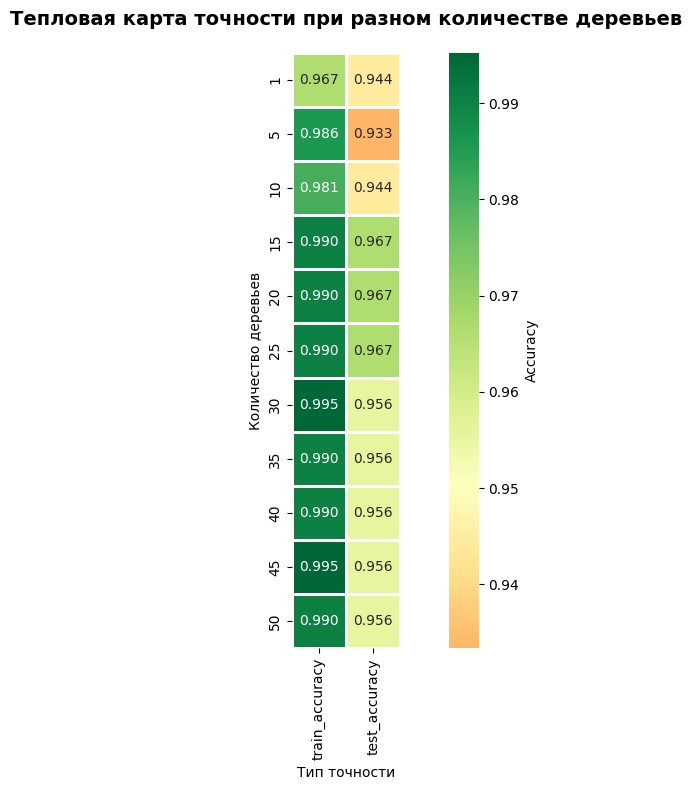

In [ ]:
plt.figure(figsize=(10, 8))

# Подготовка данных для тепловой карты
results_df = results_df.sort_values('n_trees')
heatmap_data = results_df.set_index('n_trees')[['train_accuracy', 'test_accuracy']]

# Создаем тепловую карту
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn', 
            center=0.95,
            cbar_kws={'label': 'Accuracy'},
            linewidths=1,
            square=True)

plt.title('Точность при разном количестве деревьев', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Тип точности')
plt.ylabel('Количество деревьев')
plt.tight_layout()
plt.show()

Выводы: 
1. При 10 деревьях в ансамбле мы достигли уровня точности на тесте, равной модели 1 "сильного" дерева. При этом разрыв между accuracy на тренировочных данных и на тесте выше у ансамбля, чем у 1 дерева, что свидетельствует о большей переобученности ансамбля.
2. При 15 деревьях в ансамбле accuracy на тестовой выборке стал выше, чем у модели 1 "сильного" дерева. 15 деревьев - это точка, при которой далее качество классификации не повышается.
Разрыв train/test практически одинаков у одиночного дерева и оптимального ансамбля (0.023), но ансамбль дает лучшие результаты на обеих выборках.
3. При количестве 30 деревьев и более accuracy на тестовой выборке снижается при высоком accuracy на тренировочных данных. Это говорит о том, что модель переобучается. Использовать количество деревьев 30+ не рекомендуется
Таким образом, оптимальным количеством деревьев в ансамбле в нашем эксперименте является 15. 
Несмотря на то, что при n_estimators = 20 и 25 точность на тесте равна при n_estimators = 15, для экономии ресурсов лучше использовать 15 деревьев.

Для того, чтобы окончательно сформировать рекомендацию по кол-ву используемых деревьев в ансамбле, проанализируем устойчивость модели.

Проведем теперь анализ устойчивости модели - возьмем различные показатели random_state и изучим, как будут меняться:
1. Оптимальное кол-во деревьев.
2. Показатели Accuracy

In [256]:
from tqdm import tqdm

n_trees_range = [5, 10, 15, 20, 25] # сократим кол-во вариаций численности деревьев
                                    # для ускорения выполнения кода
stability_results = []

base_seeds = [32, 42, 55, 70, 77, 80, 88]
total_combinations = len(base_seeds) * len(n_trees_range)

print(f"Всего комбинаций: {total_combinations}")
print(f"Base seeds: {base_seeds}")
print(f"n_trees range: {n_trees_range}")

# Основной прогресс-бар
main_pbar = tqdm(total=total_combinations, desc="Общий прогресс")

for base_seed in base_seeds:
    seed_results = []
    
    for n_trees in n_trees_range:
        trees = []
        predictions_train = {}
        predictions_test = {}
        
        # Прогресс-бар для деревьев в ансамбле
        tree_pbar = tqdm(range(n_trees), desc=f"Seed {base_seed}, trees {n_trees}", leave=False)
        
        for i in tree_pbar:
            tree = tree_for_begging(X_train, y_train, random_state=i+base_seed)
            predictions_train[f"tree_{i}"] = predict(tree, X_train)
            predictions_test[f"tree_{i}"] = predict(tree, X_test)
        
        tree_pbar.close()
        
        y_ensemble_train = majority_vote(predictions_train)
        y_ensemble_test = majority_vote(predictions_test)
        
        train_acc = accuracy_score(y_train, y_ensemble_train)
        test_acc = accuracy_score(y_test, y_ensemble_test)
        
        seed_results.append({
            'base_seed': base_seed,
            'n_trees': n_trees,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        })
        
        # ОБНОВЛЯЕМ ОСНОВНОЙ ПРОГРЕСС-БАР
        main_pbar.update(1)
        main_pbar.set_postfix({
            'current_seed': base_seed,
            'current_n_trees': n_trees,
            'train_acc': f'{train_acc:.3f}',
            'test_acc': f'{test_acc:.3f}'
        })
    
    # Находим оптимальное количество деревьев для данного seed
    seed_df = pd.DataFrame(seed_results)
    best_test_acc = seed_df['test_accuracy'].max()
    best_models = seed_df[seed_df['test_accuracy'] == best_test_acc]
    optimal_model = best_models.loc[best_models['n_trees'].idxmin()]
    
    stability_results.append({
        'base_seed': base_seed,
        'optimal_n_trees': optimal_model['n_trees'],
        'optimal_test_accuracy': optimal_model['test_accuracy'],
        'optimal_train_accuracy': optimal_model['train_accuracy']
    })

main_pbar.close()

# Вывод результатов
stability_df = pd.DataFrame(stability_results)
print("\n" + "-"*50)
print("АНАЛИЗ УСТОЙЧИВОСТИ МОДЕЛИ")
print("-"*50)
print(stability_df.round(3))

# Статистика
print("\Итоги:")
print(f"Всего экспериментов: {len(stability_df)}")
print(f"Среднее оптимальное кол-во деревьев: {stability_df['optimal_n_trees'].mean():.1f}")
print(f"Средняя точность на тесте: {stability_df['optimal_test_accuracy'].mean():.3f}")


Всего комбинаций: 35
Base seeds: [32, 42, 55, 70, 77, 80, 88]
n_trees range: [5, 10, 15, 20, 25]


Общий прогресс: 100%|██████████| 35/35 [11:11<00:00, 19.18s/it, current_seed=88, current_n_trees=25, train_acc=0.986, test_acc=0.956]


--------------------------------------------------
АНАЛИЗ УСТОЙЧИВОСТИ МОДЕЛИ
--------------------------------------------------
   base_seed  optimal_n_trees  optimal_test_accuracy  optimal_train_accuracy
0         32              5.0                  0.956                   0.986
1         42             15.0                  0.967                   0.990
2         55              5.0                  0.967                   0.986
3         70              5.0                  0.956                   0.981
4         77              5.0                  0.967                   0.986
5         80             10.0                  0.956                   0.986
6         88              5.0                  0.956                   0.981
\Итоги:
Всего экспериментов: 7
Среднее оптимальное кол-во деревьев: 7.1
Средняя точность на тесте: 0.960


Выводы относительно устойчивости модели:

1. Модель не устойчива по показателю "оптимальное количество деревьев". Рекомендация "15 деревьев" только в одном эксперименте получилась.
Чаще всего модель показывала оптимальные результаты на 5 деревьях

2. Модель устойчива по показателю accuracy - при оптимальном кол-ве деревьев на тестовой выборке accuracy принимает значения 0,956-0,967

Рекомендация по выбору кол-ва деревьев: 5-10

Объяснением неустойчивости модели могут быть:
1. Небольшой датасет
2. Всего 2 признака
3. Случайные флуктуации 


### Этап 3. Кластеризация и понижение размерности

Переходим к задаче кластеризации, в которой исследуем, как разные методы группируют данные

In [272]:
# 1. Загрузим набор данных
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
print(X.info())
X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB
None


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Видим, что у нас датасет состоит из 4 признаков и 150 наблюдений. Пропуски отсутствуют.


2. Перед кластеризацией выполним масштабирование признаков, так как признаки имеют разные масштабы, а k-means чувствителен к ним:

In [283]:
X_scaled = (X - X.mean()) / X.std()

3. Реализуем вручную алгоритм k-means

In [ ]:
# 3.1. Напишем функцию для ручной реализации k-means

def kmeans (X, n_clusters, max_iters=100, tolerance=1e-4, random_state=42):
       
    np.random.seed(random_state)
    
    # 1. Инициализация центроидов случайным образом
    n_samples, n_features = X.shape
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X.iloc[indices].values
    
    # Переменные для отслеживания сходимости
    n_clusters = centroids.shape[0]
    n_features = centroids.shape[1]

    centroids_old = np.zeros((n_clusters, n_features)) #здесь храним старые значения центроидов
    labels = np.zeros(n_samples, dtype=int) # здесь храним метки кластеров
    
    for iteration in range(max_iters):
        # 2. Назначение точек ближайшему центроиду
        # Вычисляем расстояния от каждой точки до каждого центроида
        distances = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            distances[:, i] = np.sqrt(np.sum((X.values - centroids[i])**2, axis=1))
        
        # Находим ближайший центроид для каждой точки
        labels = np.argmin(distances, axis=1)
        
        # 3. Пересчет центроидов
        centroids_old = centroids.copy()
        for i in range(n_clusters):
            if np.sum(labels == i) > 0:  # проверяем, что кластер не пустой
                centroids[i] = X.values[labels == i].mean(axis=0)
        
        # 4. Проверка сходимости
        centroid_shift = np.sqrt(np.sum((centroids - centroids_old)**2, axis=1))
        max_shift = np.max(centroid_shift)
        
                
        if max_shift < tolerance:
            break
    
    else:
        print(f"Достигнут максимум итераций ({max_iters})")
    
    return labels, centroids



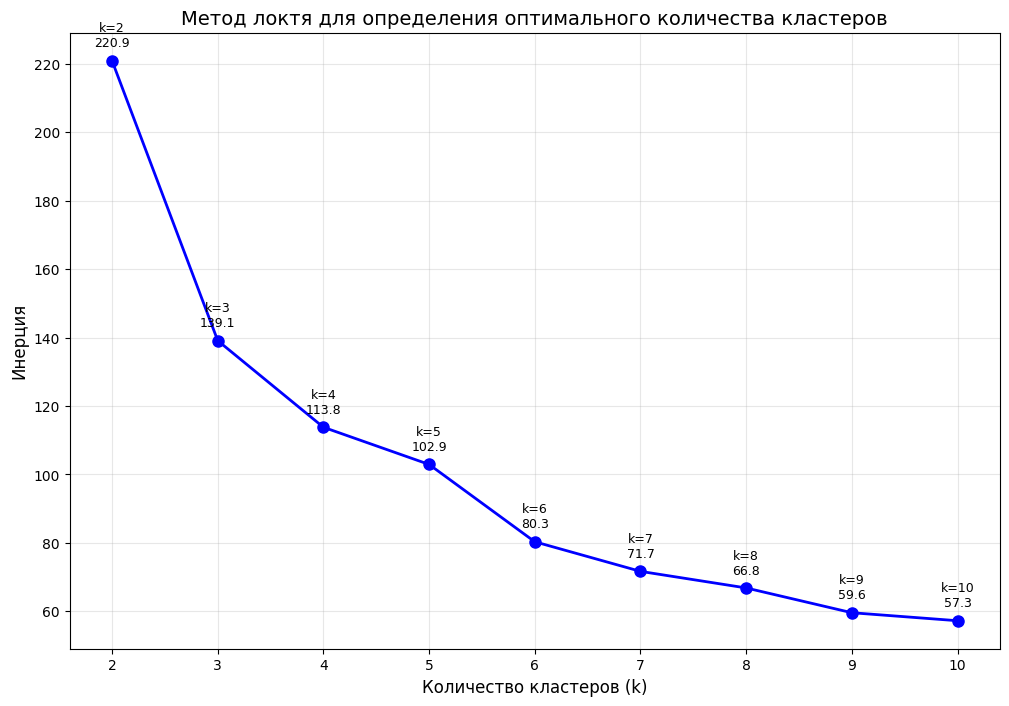

In [299]:
# 3.2. Для того, чтобы выбрать количество кластеров, воспользуемся методом локтя

#функция для расчета инерции:
def inertia (X, labels, centroids): 
   
    # Сопоставляем каждой точке ее центроид
    point_centroids = centroids[labels]
    
    # Вычисляем квадраты расстояний и суммируем
    squared_distances = np.sum((X - point_centroids)**2, axis=1)
    inertia_value = np.sum(squared_distances)
    
    return inertia_value

inertia_values = []
for k in range (2, 11):
    labels, centroids = kmeans (X_scaled, n_clusters=k, max_iters=100, tolerance=1e-4, random_state=42)
    inertia_val = inertia(X_scaled, labels, centroids)
    inertia_values.append(inertia_val)
    
#Визуализируем инерцию

plt.figure(figsize=(12, 8))
plt.plot(range (2, 11), inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Инерция', fontsize=12)
plt.title('Метод локтя для определения оптимального количества кластеров', fontsize=14)
plt.grid(True, alpha=0.3)

# Подписываем точки
for i, (k, i) in enumerate(zip(range (2, 11)
                                     , inertia_values)):
    plt.annotate(f'k={k}\n{i:.1f}', 
                (k, i), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', 
                fontsize=9)

plt.show()   

Предлагаем взять n_clusters=3, т.к. на данном значении наблюдается наиболее резкое падение инерции

In [300]:

# Применяем алгоритм
labels, centroids = kmeans(X_scaled, n_clusters=3, random_state=42)

# Визуализация результатов
print("Результаты кластеризации")
print(f"Размеры кластеров: {np.bincount(labels)}")
print(f"Финальные центроиды:\n{centroids}")

Результаты кластеризации
Размеры кластеров: [56 50 44]
Финальные центроиды:
[[-0.0113575  -0.8730834   0.37581671  0.3101145 ]
 [-1.01119138  0.85041372 -1.30063009 -1.25070352]
 [ 1.16353612  0.14481784  0.99967656  1.02656282]]


4. Реализуем метод понижения размерности РСА.


Будем действовать согласно алгоритму РСА:

4.1. Стандартизировать данные.
Наши данные уже стандартизированы, это не требуется

4.2. Рассчитать ковариационную матрицу для объектов.
Сделаем это в коде ниже


In [ ]:
cov_mat = np.cov(X_scaled.T)
cov_mat

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

4.3.Рассчитать собственные значения и собственные векторы для ковариационной матрицы:

In [331]:
eigen_val, eigen_vectors = np.linalg.eig(cov_mat)
print(eigen_val)
print(eigen_vectors)

[2.91849782 0.91403047 0.14675688 0.02071484]
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


4.4. Отсортировать собственные значения и соответствующие им собственные векторы.
В python уже реализован вывод по убыванию собственных значений. Дополнительная сортировка не требуется.

4.5 Выбрать k  наибольших собственных значений и сформировать матрицу соответствующих собственных векторов.
Для того, чтобы определить количество собственных значений, посмотрим на % объясненной дисперсии:



In [303]:
total_variance = sum(eigen_val)
explained_variance_ratio = [val/total_variance for val in eigen_val]
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Объясненная дисперсия:")
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {var:.1%} (кумулятивно: {cum_var:.1%})")

Объясненная дисперсия:
PC1: 73.0% (кумулятивно: 73.0%)
PC2: 22.9% (кумулятивно: 95.8%)
PC3: 3.7% (кумулятивно: 99.5%)
PC4: 0.5% (кумулятивно: 100.0%)


Видим, что всего 2 первых компоненты объясняют более 95% дисперсии. Возьмем k=2

In [304]:
#Сформируем матрицу собственных векторов при k=2:
matrix_eigen = eigen_vectors[:, :2]
matrix_eigen.shape

(4, 2)

4.6 Преобразовать исходные данные, умножив матрицу данных на матрицу отобранных собственных векторов

In [305]:
X_pca = X_scaled.values @ matrix_eigen
X_pca_df = pd.DataFrame(X_pca, columns=['Comp1', 'Comp2'])
X_pca_df.head()

,Comp1,Comp2
0,-2.257141,-0.478424
1,-2.074013,0.671883
2,-2.356335,0.340766
3,-2.291707,0.595400
4,-2.381863,-0.644676


Реализуем алгоритм k-means для данных с учетом снижения размерности

In [307]:
labels_pca, centroids_pca = kmeans(X_pca_df, n_clusters=3, random_state=42)

# Визуализация результатов
print("Результаты кластеризации")
print(f"Размеры кластеров: {np.bincount(labels_pca)}")
print(f"Финальные центроиды:\n{centroids_pca}")

print(f' Инерция после применения РСА: {inertia (X_pca_df, labels_pca, centroids_pca)}')

Результаты кластеризации
Размеры кластеров: [55 50 45]
Финальные центроиды:
[[ 0.61536214  0.79579238]
 [-2.21732492 -0.28796275]
 [ 1.71158507 -0.65267652]]
 Инерция после применения РСА: 114.41856070404401


Инерция при k=3 снизилась после понижения размерности: 
Было: 139,1
Стало: 114,4
Это говорит о росте качества кластеризации. Рост качества произошел за счет того, что мы с помощью РСА:
- убрали шум
- убрали мультиколлинеарность (если была)
- упростили структуру и сосредоточили алгоритм на главных компонентах

Проверим дополнительно изменение в качестве кластеризации по коэффициенту силуэта:

In [332]:
from sklearn.metrics import silhouette_score

# Первоначальная кластеризация:
silhouette_initial = silhouette_score(X_scaled, labels)
print(f"Silhouette score: {silhouette_initial:.3f}")

# Для PCA данных
silhouette_pca = silhouette_score(X_pca_df, labels_pca)
print(f"Silhouette score (PCA): {silhouette_pca:.3f}")

Silhouette score: 0.463
Silhouette score (PCA): 0.511


Таким образом, рост коэффициента силуэта с 0,463 до 0,511 подтверждает улучшение качества кластеризации

Далее сравним нашу реализацию с sklearn

In [323]:
from sklearn.cluster import KMeans as SKLearnKMeans

# 1. KMeans из sklearn для сравнения
sklearn_kmeans = SKLearnKMeans(n_clusters=3, random_state=42, n_init=10)
labels_sklearn = sklearn_kmeans.fit_predict(X_pca_df)
centroids_sklearn = sklearn_kmeans.cluster_centers_

# 2. Сравнение метрик
inertia_manual = inertia(X_pca_df.values, labels_pca, centroids_pca)
inertia_sklearn = sklearn_kmeans.inertia_

silhouette_manual = silhouette_score(X_pca_df, labels_pca)
silhouette_sklearn = silhouette_score(X_pca_df, labels_sklearn)

print("Сравнение результатов")
print(f"{'Метрика':<30} {'Наша реализация':30} {'Sklearn':<30}")
print(f"{'-'*50}")
print(f"{'Inertia':<30} {inertia_manual:<30.2f} {inertia_sklearn:<30.2f}")
print(f"{'Silhouette':<30} {silhouette_manual:<30.3f} {silhouette_sklearn:<30.3f}")
print(f"{'Размеры кластеров':<30} {str(np.bincount(labels_pca)):<30} {str(np.bincount(labels_sklearn)):<30}")

Сравнение результатов
Метрика                        Наша реализация                Sklearn                       
--------------------------------------------------
Inertia                        114.42                         114.25                        
Silhouette                     0.511                          0.509                         
Размеры кластеров              [55 50 45]                     [53 50 47]                    


Сравенение метрик показывает, что наша реализация сопоставима с решением Sklearn:
- инерция примерно одинакова
- к-ты силуэта тоже близки (в нашей реализации даже немного выше)
- численность кластеров схожа, но у sklearn классы немного более сбалансированы

Визуализируем кластеризации, полученные ручным способом и с помощью sklearn

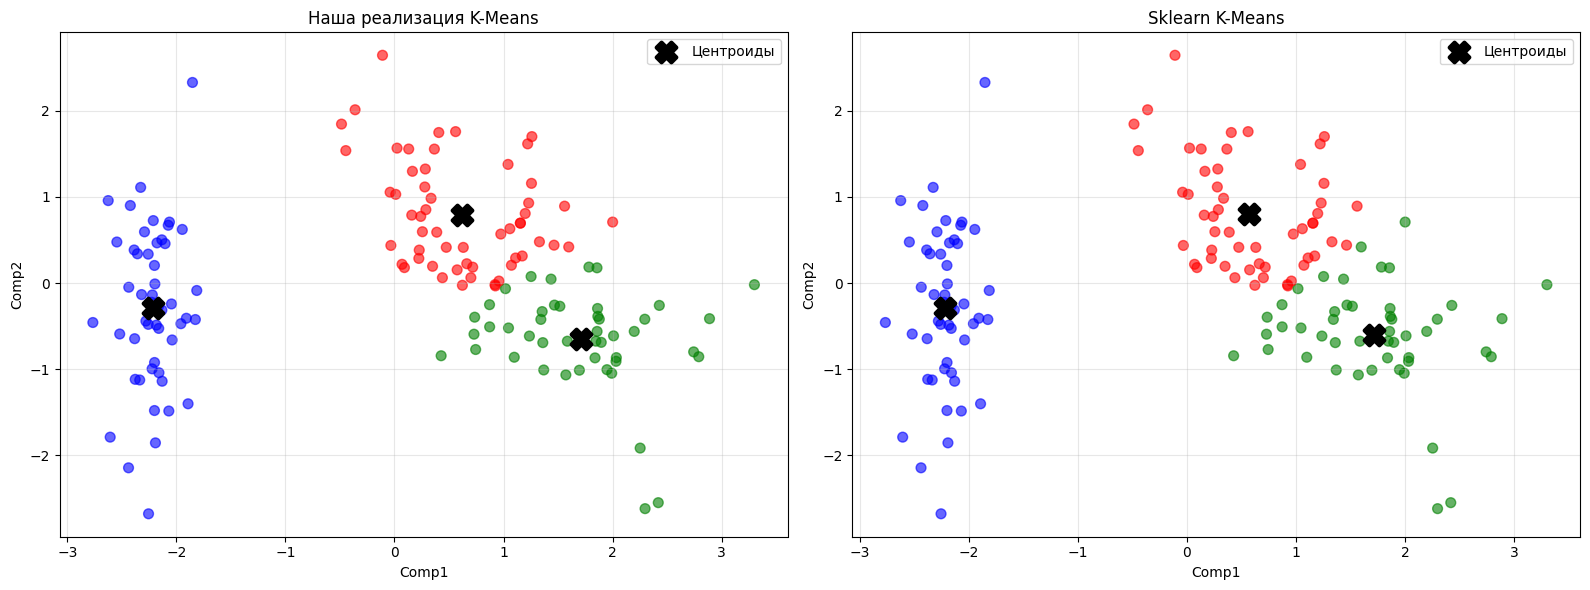

Сопоставление центроидов
Матрица попарных расстояний между центроидами:
[[0.04549636 3.03292616 1.77778497]
 [2.99443495 0.         3.94504444]
 [1.85067564 3.94580154 0.05193465]]
\Наилучшее сопоставление центроидов:
Наш центроид 0 → Sklearn центроид 0 (расстояние: 0.0455)
Наш центроид 1 → Sklearn центроид 1 (расстояние: 0.0000)
Наш центроид 2 → Sklearn центроид 2 (расстояние: 0.0519)
Сравнение координат сопоставленных центроидов:
Центроид   Наш Comp1  Sklearn Comp1 Наш Comp2  Sklearn Comp2 Расстояние
--------------------------------------------------------------------------------
0          0.6154     0.5707       0.7958     0.8045       0.0455    
1          -2.2173    -2.2173      -0.2880    -0.2880      0.0000    
2          1.7116     1.7153       -0.6527    -0.6009      0.0519    
Среднее расстояние между сопоставленными центроидами: 0.0325
Максимальное расстояние: 0.0519


In [325]:
from sklearn.metrics import pairwise_distances

# Создаем фигуру с 2 подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Цветовая схема для кластеров
colors = ['red', 'blue', 'green']

# 1. Наша реализация K-Means
sc1 = ax1.scatter(X_pca_df['Comp1'], X_pca_df['Comp2'], 
                  c=[colors[i] for i in labels_pca], alpha=0.6, s=50)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           marker='X', s=200, color='black', linewidths=3, label='Центроиды')
ax1.set_xlabel('Comp1')
ax1.set_ylabel('Comp2')
ax1.set_title(f'Наша реализация K-Means')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Sklearn K-Means
sc2 = ax2.scatter(X_pca_df['Comp1'], X_pca_df['Comp2'], 
                  c=[colors[i] for i in labels_sklearn], alpha=0.6, s=50)
ax2.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], 
           marker='X', s=200, color='black', linewidths=3, label='Центроиды')
ax2.set_xlabel('Comp1')
ax2.set_ylabel('Comp2')
ax2.set_title(f'Sklearn K-Means')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Сопоставление центроидов по минимальному расстоянию
print("Сопоставление центроидов")
distances = pairwise_distances(centroids_pca, centroids_sklearn)
print("Матрица попарных расстояний между центроидами:")
print(distances)

# Находим наилучшее сопоставление
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(distances)

print("\Наилучшее сопоставление центроидов:")
for i, j in zip(row_ind, col_ind):
    dist = distances[i, j]
    print(f"Наш центроид {i} → Sklearn центроид {j} (расстояние: {dist:.4f})")

# 4. Сравнение координат сопоставленных центроидов
print("Сравнение координат сопоставленных центроидов:")
print(f"{'Центроид':<10} {'Наш Comp1':<10} {'Sklearn Comp1':<12} {'Наш Comp2':<10} {'Sklearn Comp2':<12} {'Расстояние':<10}")
print("-" * 80)
for i, j in zip(row_ind, col_ind):
    our_centroid = centroids_pca[i]
    sklearn_centroid = centroids_sklearn[j]
    dist = distances[i, j]
    print(f"{i:<10} {our_centroid[0]:<10.4f} {sklearn_centroid[0]:<12.4f} "
          f"{our_centroid[1]:<10.4f} {sklearn_centroid[1]:<12.4f} {dist:<10.4f}")

print(f"Среднее расстояние между сопоставленными центроидами: {np.mean(distances[row_ind, col_ind]):.4f}")
print(f"Максимальное расстояние: {np.max(distances[row_ind, col_ind]):.4f}")


Вывод: центроиды очень близки. По кластеру 1 полное совпадение координат.
Таким образом, ручная реализация максимально близка к библиотечному решению как по критериям качества, так и близости центроидов

### Этап 4. Итоговый анализ

Итоги:

1. Что общего у дерева решений, ансамбля и кластеризации с точки зрения принципов разделения данных и интерпретации результатов?

Все три метода решают одну задачу - поиск похожих по n-признакам групп в данных. Т.е. в основу методов положена группировка объектов по схожести по признакам.

С точки зрения интерпретации методы похожи в части:
- все методы определяют правила принадлежности объекта к группе (дерево - через предикаты, k-means через расстояние до центроидов, ансамбль через голосование)
- схожих показателей качества. Во всех трех алгоритмах показатели качества в основном отвечают на вопросы: "насколько объекты внутри группы похожи" или "насколько группы отличаются друг от друга" 

2. Как параметры (глубина дерева, количество деревьев, число кластеров и др.) влияли на результаты?

Подбор параметров был важной частью решения задач. В частности:
- при реализации алгоритма дерева решений подбор глубины дерева осуществляла эмпирическим путем на основании accuracy тестовой и тренировочной выборки. При глубине = 2 и 4 был большой разрыв между accuracy на тесте и обучающей выборкой. При этом при глубине = 2 accuracy на тесте был минимальным.    
Глубина = 3 позволила достичь оптимальной разницы между accuracy на тесте и обучающей выборкой при высоком показателе не тесте

- параметр "количество деревьев" при ансамбле так же влиял на результат. В рамках экспериментов было подобрано оптимальное значение кол-ва деревьев (5-10) в текущей задаче. При меньшем количестве мы не достигли бы хорошей точности. При большем наблюдалась переобученность

-число кластеров изначально было подобрано оптимальным по методу локтя, варьирование не осуществляли (в задаче не требовалось)

3. Какие трудности возникли при реализации алгоритмов и как вы их решали?

Большинство трудностей были связаны с технической реализацией. 
В частности, была проблема в задаче на этапе 2 при анализе устойчивости модели: код выполнялся 18+ минут вместо ожидаемых 5-7
Решение: добавили прогресс-бар, сократили количество экспериментов

4. Как вы проверяли корректность своих алгоритмов и воспроизводимость экспериментов (например, фиксирование random_state, сравнение со sklearn)?

- проверяли деревья решений и k-means через сравнение с sklearn. 
   k-means: сравнение центроидов (расстояние ок.0.03) и метрик (инерция, к-т силуэта)
   дерево решений: сравнение accuracy и структуры решающих правил
Результаты получились очень похожимы, что позволило сделать вывод о корректности алгоритма

- при реализации бэггинга осуществили проверку того, что при разных random_state формируются совершенно разные деревья, следовательно, bootstrap работает правильно
